In [1]:
! pip3 install -q kaggle transformers nltk wordcloud matplotlib scikit-learn gensim datasets watermark
! pip3 install torch torchvision torchaudio
! pip3 install accelerate -U


In [2]:
%reload_ext watermark
%watermark -vp kaggle,transformers,nltk,wordcloud,matplotlib,scikit-learn,gensim,datasets


/opt/homebrew/Caskroom/miniforge/base/envs/gpu_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

kaggle      : 1.5.16
transformers: 4.35.0
nltk        : 3.8.1
wordcloud   : 1.9.2
matplotlib  : 3.8.1
scikit-learn: 1.3.2
gensim      : 4.3.2
datasets    : 2.14.6



### Carga Corpus

In [3]:
! kaggle datasets download -d arushchillar/disneyland-reviews
! unzip disneyland-reviews.zip


 99%|█████████████████████████████████████▋| 11.0M/11.1M [00:01<00:00, 15.9MB/s]
100%|██████████████████████████████████████| 11.1M/11.1M [00:01<00:00, 9.29MB/s]
Archive:  disneyland-reviews.zip
  inflating: DisneylandReviews.csv   


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./DisneylandReviews.csv", encoding="ISO-8859-1")


A fines de generar un modelo de Sentiment Analysis, generaremos una variable Target con el sentimiento de cada review en base a la variable rating de la siguiente manera:
1. Positive: Reseñas con puntaje 4 o 5
2. Neutral: Reseñas con puntaje 3
3. Negative: Reseñas con puntaje 1 y 2

In [5]:
#Genero columna target
def Target(row):
    sentiment = "positive"
    if int(row["Rating"]) == 3:
        sentiment = "neutral"
    elif int(row["Rating"]) < 3:
        sentiment = "negative"
    return sentiment

df["target"] = df.apply(Target, axis=1)
print(df.groupby(['target'])['target'].count())


target
negative     3626
neutral      5109
positive    33921
Name: target, dtype: int64


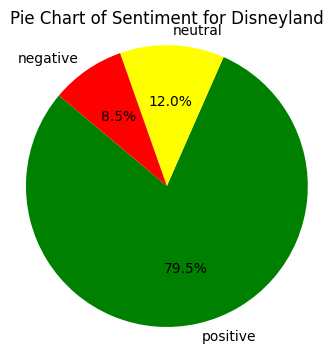

In [6]:
target_counts = df['target'].value_counts()

colors = {'positive': 'green', 'neutral': 'yellow', 'negative': 'red'}

plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=target_counts.index, colors=[colors[sentiment] for sentiment in target_counts.index], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Pie Chart of Sentiment for Disneyland')
plt.show()


### Análisis Descriptivo
Bag of Words Binarizado: asigna un 1 a todas las palabras del corpus que estén presentes en el documento

Regresión Logística para evaluar qué palabras son las más significativas por categoría

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['Review_Text'].tolist()

# vectorizer = CountVectorizer(binary=True)
# matriz_bow = vectorizer.fit_transform(corpus)

# # Convierte la matriz BoW en un diccionario de BoW binarizado para cada documento
# diccionarios_bin = [dict(zip(vectorizer.get_feature_names_out(), row.toarray()[0])) for row in matriz_bow]
# print(diccionarios_bin[0])


In [8]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# rlog = LogisticRegression()
# X = diccionarios_bin
# y = df['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
# rlog.fit(X_train, y_train)

# pred = rlog.predict(X_test)

# accuracy = accuracy_score(y_test, pred)
# reporte_clasificacion = classification_report(y_test, pred)
# matriz_confusion = confusion_matrix(y_test, pred)

# print(f"Precisión: {accuracy}")
# print(reporte_clasificacion)
# print(matriz_confusion)


In [9]:
# rlog.fit(X, y)
# betas = rlog.coef_
# print(betas)


Bag of Words con todo el corpus: Devuelve frecuencia de aparición de cada palabra

In [10]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srosati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from collections import defaultdict

import string

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained("gpt2")

diccionario = defaultdict(int)

def get_word_freqs(corpus):
    word_freqs = defaultdict(int)

    for text in corpus:
        text = text.translate(str.maketrans('', '', string.punctuation))
        filtered_text = [word.lower() for word in text.split(" ") if word.lower() not in stop_words]
        filtered_text = " ".join(filtered_text)
        words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(filtered_text)
        new_words = [word for word, _ in words_with_offsets]
        for word in new_words:
            word = word.lstrip("Ġ")
            if word != "":
                word_freqs[word] += 1
    
    return word_freqs


In [12]:
diccionario = get_word_freqs(corpus)
print(sorted(diccionario.items(), key=lambda x: x[1], reverse=True)[:15])


[('park', 44309), ('disney', 35973), ('rides', 34295), ('disneyland', 32622), ('time', 29219), ('day', 28145), ('get', 22963), ('go', 20091), ('one', 19081), ('ride', 17661), ('great', 16305), ('would', 14591), ('kids', 14135), ('food', 14129), ('place', 13367)]


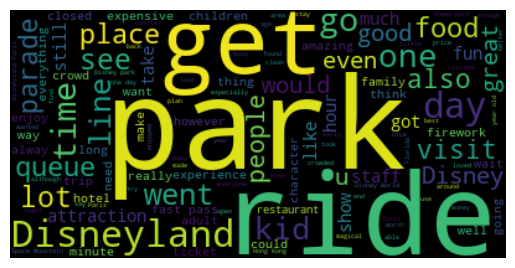

In [13]:
from wordcloud import WordCloud

def plot_word_cloud(corpus, filtered_words = []):
    filtered_words.extend(stop_words)
    text = "\n".join(corpus)

    wordcloud = WordCloud(stopwords=set(filtered_words)).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(corpus)


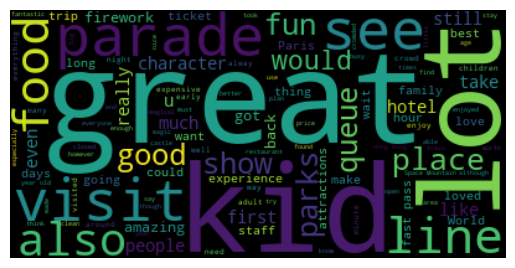

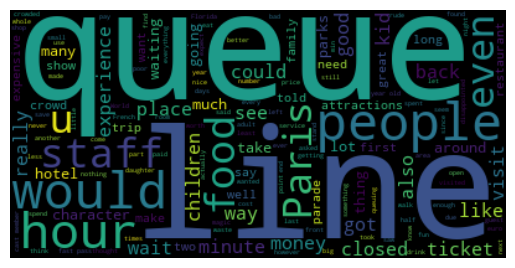

In [14]:
common_words = ["DISNEYLAND", "DISNEY", "RIDE", "RIDES", "PARK", "DAY", "GET", "ATTRACTION", "WENT", "GO", "ONE", "TIME"]
positive_corpus = df[df['target'] == 'positive']['Review_Text'].tolist()
plot_word_cloud(positive_corpus, common_words)

# neutral_corpus = df[df['target'] == 'neutral']['Review_Text'].tolist()
# plot_word_cloud(neutral_corpus, common_words)

negative_corpus = df[df['target'] == 'negative']['Review_Text'].tolist()
plot_word_cloud(negative_corpus, common_words)


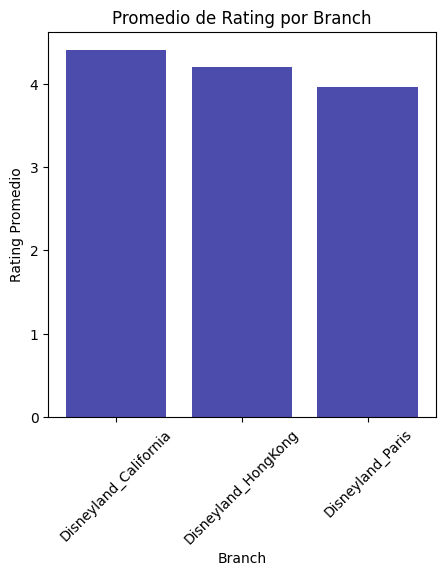

In [15]:
branch_ratings_avg = df.groupby('Branch')['Rating'].mean()

# Obtener las etiquetas de las sucursales
branch_labels = branch_ratings_avg.index

# Obtener los valores promedio de Rating
ratings_avg_values = branch_ratings_avg.values

# Crear un gráfico de barras
plt.figure(figsize=(5, 5))
plt.bar(branch_labels, ratings_avg_values, color='darkblue', alpha=0.7)
plt.xlabel('Branch')
plt.ylabel('Rating Promedio')
plt.title('Promedio de Rating por Branch')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_67618/977167236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disneyParis["target"] = df.apply(Target, axis=1)


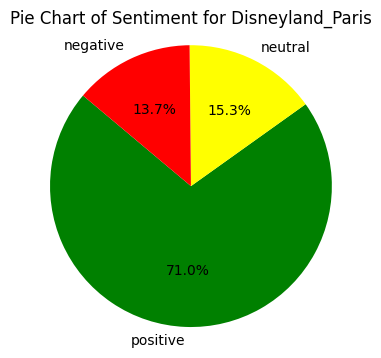

In [16]:
disneyParis = df[df['Branch'] == 'Disneyland_Paris']

disneyParis["target"] = df.apply(Target, axis=1)

target_counts_paris = disneyParis['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_paris, labels=target_counts_paris.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_Paris')
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_67618/2532616550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyHongKong["target"] = df.apply(Target, axis=1)


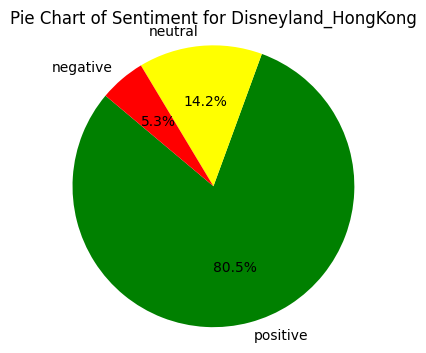

In [17]:
DisneyHongKong = df[df['Branch'] == 'Disneyland_HongKong']

DisneyHongKong["target"] = df.apply(Target, axis=1)

target_counts_hongkong = DisneyHongKong['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_hongkong, labels=target_counts_hongkong.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for Disneyland_HongKong')
plt.show()


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_67618/1374310134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DisneyCalifornia["target"] = df.apply(Target, axis=1)


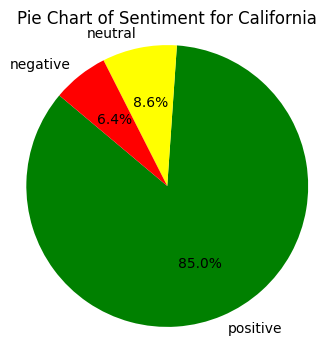

In [18]:
DisneyCalifornia = df[df['Branch'] == 'Disneyland_California']

DisneyCalifornia["target"] = df.apply(Target, axis=1)

target_counts_california = DisneyCalifornia['target'].value_counts()


colors = ['green', 'yellow', 'red']

# Crear el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(target_counts_california, labels=target_counts_california.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarte de que el gráfico sea un círculo
plt.title('Pie Chart of Sentiment for California')
plt.show()


### Vocabulario

Byte-Pair Encoding: Amplía el vocabulario con las agrupaciones de tokens más comunes

In [19]:
vocab = []

for word in diccionario.keys():
    for letter in word:
        if letter not in vocab:
            vocab.append(letter)
vocab.sort()

print(vocab)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [20]:
#Recibe todos los caracteres separados de las palabras de los documentos, los empareja y calcula la frecuencia de los emparejamientos
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in diccionario.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

splits = {word: [c for c in word] for word in diccionario.keys()}
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break


('y', 'o'): 16835
('o', 'u'): 130405
('u', 'v'): 1989
('v', 'e'): 125767
('e', 'v'): 54229
('e', 'r'): 231690


In [21]:
#Muestra el par más repetido
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)


('i', 'n') 286933


In [22]:
#encuentra en las palabras los pares indicados y los agrupa
def merge_pair(a, b, splits):
    for word in diccionario:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("i", "n", splits)

for i, key in enumerate(splits.keys()):
    print(f"{key}: {splits[key]}")
    if i >= 5:
        break


youve: ['y', 'o', 'u', 'v', 'e']
ever: ['e', 'v', 'e', 'r']
disneyland: ['d', 'i', 's', 'n', 'e', 'y', 'l', 'a', 'n', 'd']
anywhere: ['a', 'n', 'y', 'w', 'h', 'e', 'r', 'e']
youll: ['y', 'o', 'u', 'l', 'l']
find: ['f', 'in', 'd']


In [23]:
#muestra los pares más repetidos
merges = {("i", "n"): "in"}
vocab.append("in")

vocab_size = 100 #setea el máximo de pares a insertar hasta que el vocab alcance dicho tamaño

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

print(merges)


{('i', 'n'): 'in', ('e', 'r'): 'er', ('a', 'r'): 'ar', ('e', 's'): 'es', ('e', 'n'): 'en', ('a', 'n'): 'an', ('o', 'n'): 'on', ('e', 'd'): 'ed', ('s', 't'): 'st', ('in', 'g'): 'ing', ('i', 's'): 'is', ('a', 'l'): 'al', ('o', 'u'): 'ou', ('r', 'e'): 're', ('r', 'i'): 'ri', ('t', 'i'): 'ti', ('t', 'h'): 'th', ('n', 'e'): 'ne', ('p', 'ar'): 'par', ('o', 'r'): 'or', ('a', 'y'): 'ay', ('l', 'y'): 'ly', ('l', 'e'): 'le', ('a', 't'): 'at', ('i', 't'): 'it', ('d', 'is'): 'dis', ('a', 'c'): 'ac', ('c', 'h'): 'ch', ('m', 'e'): 'me', ('ne', 'y'): 'ney', ('dis', 'ney'): 'disney', ('e', 't'): 'et', ('l', 'o'): 'lo', ('l', 'd'): 'ld', ('ri', 'd'): 'rid', ('an', 'd'): 'and', ('par', 'k'): 'park', ('a', 's'): 'as', ('i', 'c'): 'ic', ('en', 't'): 'ent', ('h', 'o'): 'ho', ('a', 'd'): 'ad', ('g', 'o'): 'go', ('s', 'e'): 'se', ('i', 'd'): 'id', ('g', 'h'): 'gh', ('v', 'er'): 'ver', ('e', 'l'): 'el', ('l', 'and'): 'land', ('r', 'o'): 'ro', ('d', 'ay'): 'day', ('a', 'st'): 'ast', ('m', 'a'): 'ma', ('k', 'e'

In [24]:
print(vocab)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'in', 'er', 'ar', 'es', 'en', 'an', 'on', 'ed', 'st', 'ing', 'is', 'al', 'ou', 're', 'ri', 'ti', 'th', 'ne', 'par', 'or', 'ay', 'ly', 'le', 'at', 'it', 'dis', 'ac', 'ch', 'me', 'ney', 'disney', 'et', 'lo', 'ld', 'rid', 'and', 'park', 'as', 'ic', 'ent', 'ho', 'ad', 'go', 'se', 'id', 'gh', 'ver', 'el', 'land', 'ro', 'day', 'ast', 'ma', 'ke', 'ex', 'co', 'un', 've', 'ta', 'li', 'one', 'rides', 'od', 'pl']


TF-IDF: Devuelve el "peso" de cada palabra dentro de cada documento

In [25]:
#Genera peso para cada palabra de cada documento
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,1))
bow = vect.fit_transform(df['Review_Text'])
total_features = len(vect.vocabulary_)

print(bow[0]) #muestro pesos de palabras del documento 0


  (0, 41364)	0.1001492200981683
  (0, 25160)	0.20600502154289962
  (0, 30266)	0.11275120859486311
  (0, 7019)	0.05829991283947452
  (0, 7016)	0.12341899729910027
  (0, 31274)	0.2110461653694468
  (0, 19448)	0.14296940427420587
  (0, 15187)	0.40736440254022876
  (0, 41105)	0.054389236206943546
  (0, 40703)	0.11483688974099217
  (0, 41239)	0.055650551288347685
  (0, 10944)	0.06946702845806878
  (0, 12625)	0.16545266576934287
  (0, 42058)	0.10604310854674263
  (0, 3628)	0.08094545381697389
  (0, 15102)	0.18579588362807836
  (0, 2379)	0.1519902393440763
  (0, 21036)	0.05185857855824448
  (0, 42003)	0.10350991944390095
  (0, 34545)	0.10738379562638303
  (0, 21148)	0.11812076028098253
  (0, 32059)	0.06138379785868412
  (0, 26305)	0.04897450110208785
  (0, 26485)	0.07978823375016844
  (0, 15630)	0.1322952178630234
  (0, 15239)	0.2325311041202991
  (0, 18567)	0.10825934671193119
  (0, 21084)	0.048242108888394274
  (0, 36109)	0.1384200746449041
  (0, 23353)	0.12386423798982706
  (0, 20868)	0.12

In [26]:
#muestro orden de palabras con mayor peso del documento 0
print(sorted((bow[0,doc] for doc in range(total_features)), reverse=True))


[0.40736440254022876, 0.2325311041202991, 0.22969747696709086, 0.2110461653694468, 0.20600502154289962, 0.18579588362807836, 0.18484489677369395, 0.1792384341959779, 0.1775177835729147, 0.16545266576934287, 0.15805119886448088, 0.1536947280067274, 0.1519902393440763, 0.14955283785427426, 0.14296940427420587, 0.13934608759406988, 0.1384200746449041, 0.13734265011283436, 0.13734265011283436, 0.1322952178630234, 0.13087309645573716, 0.1305592968997868, 0.12973968688092583, 0.1258642322562421, 0.12386423798982706, 0.12341899729910027, 0.12094095334318135, 0.11812076028098253, 0.11483688974099217, 0.11275120859486311, 0.10825934671193119, 0.10738379562638303, 0.10604310854674263, 0.10350991944390095, 0.1001492200981683, 0.09246830314652003, 0.08897272401561206, 0.08094545381697389, 0.07978823375016844, 0.07673289553322223, 0.06946702845806878, 0.06138379785868412, 0.05829991283947452, 0.055650551288347685, 0.054389236206943546, 0.05185857855824448, 0.05094929285362996, 0.04897450110208785, 

In [27]:
print(bow[0]==0.40736440254022876) #la palabra con el mayor peso del doc 0 es la 15187


  (0, 15187)	True


In [28]:
vect.get_feature_names_out()[15187]


'fairly'

In [29]:
df["Review_Text"][0]


"If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides  its a Small World  is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well. "

### Análisis Predictivo

In [30]:
#Paso a Numérica la columna target
def IntTarget(row):
    sentiment = 2
    if row["target"] == 'negative':
        sentiment = 0
    elif row["target"] == 'neutral':
        sentiment = 1
    return sentiment

df["target"] = df.apply(IntTarget, axis=1)
print(df.groupby(['target'])['target'].count())


target
0     3626
1     5109
2    33921
Name: target, dtype: int64


In [35]:
import numpy as np
import pandas as pd
import torch
from IPython.display import display, HTML
import datasets
from datasets import load_metric, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
)
from sklearn.model_selection import train_test_split


In [32]:

#Genero TORCH DATASET (PARA EL MODELO PREENTRENADO)
X_train_full, X_test, y_train_full, y_test = train_test_split(corpus, df['target'], test_size=0.2, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=22)


In [33]:
def make_dict(X, y):
    return {'sentence': X, 'label': y}# for idx, key in enumerate(y.keys())]

train_data = make_dict(X_train, y_train)
val_data = make_dict(X_val, y_val)
test_data = make_dict(X_test, y_test)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

full_dataset = DatasetDict({
    'train': train_dataset,
    'val':  val_dataset,
    'test': test_dataset
})


In [36]:
def show_random_elements(dataset, num_examples=10):
    """Copiado de notebook HF :)
    """
    picks = []
    for _ in range(num_examples):
        pick = np.random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = np.random.randint(0, len(dataset)-1)
        picks.append(pick)
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(full_dataset["train"], num_examples=6)


,sentence,label
0,"Our views are coloured by visits over a number of years with our own children and now our grandson.So what do we think about it now? The park is older, there are many older attractions and a few newer ones. A number were closed for refurbishment but we did not see any work going on while we were there Pirates of the Caribbean, Frontier land lake ride and Its a Small world were important disappointments. Disney Studios was enjoyed, particularly the motor stunt show, Armagedon, the backlot visit and the diner lunch.Disneyland its self still had magic for our 11 year old grandson but we were very aware of the shortfalls. If these can be defined with one word it is Queue Typically we would queue for 30 or 40 minutes for a 4 or 5 minute ride, the more popular the ride the longer the queue, sometimes up to an hour. Fastrack place marking did not work well as we were told on occasion they had no more places left for the day.High volume food services and washrooms were good, site cleaning was excellent but many surfaces were showing their age. The traditional parade at 1730 was as good as we remember but seating for viewing very limited (shows our age) a very excited 11 year old was quite taken by it all.We (2 adults 1 child) paid 230 for the Express bus from Paris, entry to Disney Studios and Disneyland for the day we used 8 facilities rides, saw the parade and bought some merchandise and two meals.Perhaps we could have pushed it harder but we were there to enjoy the day. We have the distinct impression Disney are packing in the crowds but failing to increase the number of attractions. I think we can be confident Disney understand the mechanics of crowd flow, spending and management so the present situation is by design I'm not sure I want to be part of it any more it certainly was not cost effective for us.",1
1,"I've visited many other Disney parks, all have their charm, but none of them feel as rich and lived in as the original Disneyland.",2
2,"I love Disneyland, and it never fails to let me down. Always guaranteed a good time, no matter what time of year I go. It was mid May this trip and the weather was perfect, not too hot, not too cold, lines not too long.",2
3,Try to go during off season and not a weekend. We paid extra to use the system where you reserve a spot in line on your phone. It worked well and was worth the money. Lots of stuff to do and we liked that we could bring our baby with us on a lot of the rides.,2
4,"Don't assume it's for kids only or those who love the Disney movies and cartoons because it isn't. This was our third visit!There are lots of rides for teenagers and adults aswell as small children. There's definitely something for everyone and is a fun place to be.You can buy a one day pass. You don't have to go everyday.I loved the space mountain ride, the haunted hotel with the lift dropping and a few of the sit down shows with the 3D glasses. It can be pricey in terms of food and drink, but they have something for everyone and to suit every budget. It's a once in a life time experience and I would definitely love to return.Euro Disney is very easy to get to from most rail stations in Paris in less than an hour and a shuttle bus from the station will drop you to the park or you can get off at the station literally a short walking distance from the park.I hope everyone who goes has an absolutely amazing time :)",2
5,"My wife and I had never taken our 11 12 year old to Disneyland before April of 2013 because we wanted them to be tall enough to ride all of the fun rides and wanted them to create a memory. My wife and I have been going to Disneyland for over 30 years on various occasions. You'd think that after all of that time, Disneyland would get stale and old. That was certainly not the case. All of the rides were exciting and fun for the entire family. Mom and Dad, 20 year old son, 12 year old son and 11 year old daughter had the time of our lives and will be a cherished memory forever.

In [37]:
print("distribucion de clases:")
for k in full_dataset.keys():
    print(k)
    print(pd.Series(full_dataset[k]["label"]).value_counts())
    print("-"*70)


distribucion de clases:
train
2    21678
1     3322
0     2299
Name: count, dtype: int64
----------------------------------------------------------------------
val
2    5482
1     773
0     570
Name: count, dtype: int64
----------------------------------------------------------------------
test
2    6761
1    1014
0     757
Name: count, dtype: int64
----------------------------------------------------------------------


In [38]:
model_checkpoint = "distilbert-base-cased"


In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [40]:
def tokenize_fn(examples):
    """Sin aplicar padding --> lo aplicamos luego en cada batch de entrenamiento
    """
    return tokenizer(examples["sentence"], truncation=True)


In [41]:
tokenized_dataset = full_dataset.map(tokenize_fn, batched=True, batch_size=32)


Map: 100%|██████████| 8532/8532 [00:01<00:00, 8066.69 examples/s]


In [42]:
# map ignores tensor formatting while writing a cache file
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


In [43]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)


mps


In [44]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [45]:
# freeze todas las capas
for param in model.parameters():
    param.requires_grad = False


In [46]:
# descongelar las ultimas capas
for param in model.pre_classifier.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True
# y el ultimo transformer block:
for param in model.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

# tambien se puede ajustar todas (no congelar ninguna)


In [47]:
metric_name = "matthews_correlation"
metric = load_metric(metric_name)


/var/folders/d8/y6xtk4kx5r7ctcr0s418mrz80000gn/T/ipykernel_67618/3715655591.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(metric_name)


In [48]:
model_name = model_checkpoint.split("/")[-1]


In [49]:
args = TrainingArguments(
    f"{model_name}-finetuned-cola",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    seed=33,
)


In [50]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    #print(predictions.mean())
    return metric.compute(predictions=predictions, references=labels)


In [51]:
# pasamos el tokenizer para que aplique el padding en cada batch
# la alternativa es un usar un data_collator propio
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [52]:
trainer.train()


  0%|          | 0/17070 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  3%|▎         | 500/17070 [13:28<5:17:03,  1.15s/it] 

{'loss': 0.1308, 'learning_rate': 1.9414176918570594e-05, 'epoch': 0.29}


  6%|▌         | 1000/17070 [28:22<6:56:43,  1.56s/it]

{'loss': 0.1173, 'learning_rate': 1.8828353837141184e-05, 'epoch': 0.59}


  9%|▉         | 1500/17070 [41:52<6:12:06,  1.43s/it] 

{'loss': 0.108, 'learning_rate': 1.8242530755711776e-05, 'epoch': 0.88}


                                                      
 10%|█         | 1707/17070 [55:37<8:46:43,  2.06s/it]

{'eval_loss': 0.10958023369312286, 'eval_matthews_correlation': 0.12901510901513158, 'eval_runtime': 533.8643, 'eval_samples_per_second': 12.784, 'eval_steps_per_second': 0.8, 'epoch': 1.0}


 12%|█▏        | 2000/17070 [1:03:19<5:18:46,  1.27s/it] 

{'loss': 0.1089, 'learning_rate': 1.765670767428237e-05, 'epoch': 1.17}


 15%|█▍        | 2500/17070 [1:16:32<4:57:21,  1.22s/it] 

{'loss': 0.1075, 'learning_rate': 1.7070884592852958e-05, 'epoch': 1.46}


 18%|█▊        | 3000/17070 [1:30:09<6:51:59,  1.76s/it] 

{'loss': 0.1065, 'learning_rate': 1.648506151142355e-05, 'epoch': 1.76}


                                                         
 20%|██        | 3414/17070 [1:49:47<9:50:28,  2.59s/it]

{'eval_loss': 0.11156078428030014, 'eval_matthews_correlation': 0.1325556962028899, 'eval_runtime': 455.8691, 'eval_samples_per_second': 14.971, 'eval_steps_per_second': 0.937, 'epoch': 2.0}


 21%|██        | 3500/17070 [1:51:55<6:50:35,  1.82s/it]   

{'loss': 0.1014, 'learning_rate': 1.5899238429994144e-05, 'epoch': 2.05}


 23%|██▎       | 4000/17070 [2:06:14<6:55:53,  1.91s/it] 

{'loss': 0.1006, 'learning_rate': 1.5313415348564736e-05, 'epoch': 2.34}


 26%|██▋       | 4500/17070 [2:21:06<8:16:59,  2.37s/it] 

{'loss': 0.1048, 'learning_rate': 1.4727592267135327e-05, 'epoch': 2.64}


 29%|██▉       | 5000/17070 [2:35:47<4:53:31,  1.46s/it] 

{'loss': 0.0989, 'learning_rate': 1.4141769185705918e-05, 'epoch': 2.93}


                                                         
 30%|███       | 5121/17070 [2:46:03<11:09:38,  3.36s/it]

{'eval_loss': 0.11756022274494171, 'eval_matthews_correlation': 0.12044314058153213, 'eval_runtime': 435.9804, 'eval_samples_per_second': 15.654, 'eval_steps_per_second': 0.979, 'epoch': 3.0}


 32%|███▏      | 5500/17070 [2:56:06<4:14:00,  1.32s/it]   

{'loss': 0.0939, 'learning_rate': 1.355594610427651e-05, 'epoch': 3.22}


 35%|███▌      | 6000/17070 [3:09:36<5:11:34,  1.69s/it] 

{'loss': 0.1011, 'learning_rate': 1.29701230228471e-05, 'epoch': 3.51}


 38%|███▊      | 6500/17070 [3:23:36<3:39:28,  1.25s/it] 

{'loss': 0.092, 'learning_rate': 1.2384299941417693e-05, 'epoch': 3.81}


                                                         
 40%|████      | 6828/17070 [3:39:35<9:00:03,  3.16s/it]

{'eval_loss': 0.11598137021064758, 'eval_matthews_correlation': 0.13187005835091048, 'eval_runtime': 424.3874, 'eval_samples_per_second': 16.082, 'eval_steps_per_second': 1.006, 'epoch': 4.0}


 41%|████      | 7000/17070 [3:44:21<3:53:41,  1.39s/it]   

{'loss': 0.0966, 'learning_rate': 1.1798476859988284e-05, 'epoch': 4.1}


 44%|████▍     | 7500/17070 [3:58:10<7:06:53,  2.68s/it] 

{'loss': 0.0896, 'learning_rate': 1.1212653778558875e-05, 'epoch': 4.39}


 47%|████▋     | 8000/17070 [4:10:52<7:37:26,  3.03s/it] 

{'loss': 0.0925, 'learning_rate': 1.062683069712947e-05, 'epoch': 4.69}


 50%|████▉     | 8500/17070 [4:24:10<3:12:50,  1.35s/it] 

{'loss': 0.0947, 'learning_rate': 1.004100761570006e-05, 'epoch': 4.98}


                                                        
 50%|█████     | 8535/17070 [4:31:56<6:24:37,  2.70s/it]

{'eval_loss': 0.1299562305212021, 'eval_matthews_correlation': 0.13130202758645348, 'eval_runtime': 412.0296, 'eval_samples_per_second': 16.564, 'eval_steps_per_second': 1.036, 'epoch': 5.0}


 53%|█████▎    | 9000/17070 [4:44:53<3:46:11,  1.68s/it]   

{'loss': 0.0928, 'learning_rate': 9.455184534270651e-06, 'epoch': 5.27}


 56%|█████▌    | 9500/17070 [4:57:55<2:36:15,  1.24s/it]

{'loss': 0.092, 'learning_rate': 8.869361452841242e-06, 'epoch': 5.57}


 59%|█████▊    | 10000/17070 [5:10:41<3:03:00,  1.55s/it]

{'loss': 0.0869, 'learning_rate': 8.283538371411835e-06, 'epoch': 5.86}


                                                         
 60%|██████    | 10242/17070 [5:23:54<1:45:28,  1.08it/s]

{'eval_loss': 0.13571923971176147, 'eval_matthews_correlation': 0.1303689393176999, 'eval_runtime': 402.6622, 'eval_samples_per_second': 16.95, 'eval_steps_per_second': 1.06, 'epoch': 6.0}


 62%|██████▏   | 10500/17070 [5:31:14<2:26:27,  1.34s/it]   

{'loss': 0.084, 'learning_rate': 7.697715289982426e-06, 'epoch': 6.15}


 64%|██████▍   | 11000/17070 [5:43:56<2:12:25,  1.31s/it]

{'loss': 0.0824, 'learning_rate': 7.111892208553017e-06, 'epoch': 6.44}


 67%|██████▋   | 11500/17070 [5:57:24<1:34:58,  1.02s/it]

{'loss': 0.0879, 'learning_rate': 6.526069127123609e-06, 'epoch': 6.74}


                                                         
 70%|███████   | 11949/17070 [6:16:50<4:20:46,  3.06s/it]

{'eval_loss': 0.14416702091693878, 'eval_matthews_correlation': 0.14333445508336234, 'eval_runtime': 424.6234, 'eval_samples_per_second': 16.073, 'eval_steps_per_second': 1.006, 'epoch': 7.0}


 70%|███████   | 12000/17070 [6:18:16<1:55:07,  1.36s/it]   

{'loss': 0.0883, 'learning_rate': 5.9402460456942015e-06, 'epoch': 7.03}


 73%|███████▎  | 12500/17070 [6:31:30<2:12:57,  1.75s/it]

{'loss': 0.0833, 'learning_rate': 5.3544229642647925e-06, 'epoch': 7.32}


 76%|███████▌  | 13000/17070 [6:44:32<1:50:15,  1.63s/it]

{'loss': 0.0804, 'learning_rate': 4.768599882835384e-06, 'epoch': 7.62}


 79%|███████▉  | 13500/17070 [6:57:53<1:14:42,  1.26s/it]

{'loss': 0.0756, 'learning_rate': 4.182776801405975e-06, 'epoch': 7.91}


                                                         
 80%|████████  | 13656/17070 [7:08:55<2:39:50,  2.81s/it]

{'eval_loss': 0.15441939234733582, 'eval_matthews_correlation': 0.11558786223333116, 'eval_runtime': 420.712, 'eval_samples_per_second': 16.222, 'eval_steps_per_second': 1.015, 'epoch': 8.0}


 82%|████████▏ | 14000/17070 [7:18:06<1:39:19,  1.94s/it]   

{'loss': 0.0774, 'learning_rate': 3.5969537199765675e-06, 'epoch': 8.2}


 85%|████████▍ | 14500/17070 [7:30:49<49:27,  1.15s/it]  

{'loss': 0.0786, 'learning_rate': 3.011130638547159e-06, 'epoch': 8.49}


 88%|████████▊ | 15000/17070 [7:43:30<52:20,  1.52s/it]  

{'loss': 0.0738, 'learning_rate': 2.425307557117751e-06, 'epoch': 8.79}


                                                         
 90%|█████████ | 15363/17070 [7:59:33<2:21:49,  4.98s/it]

{'eval_loss': 0.15930534899234772, 'eval_matthews_correlation': 0.12688816696580998, 'eval_runtime': 425.9957, 'eval_samples_per_second': 16.021, 'eval_steps_per_second': 1.002, 'epoch': 9.0}


 91%|█████████ | 15500/17070 [8:03:20<33:23,  1.28s/it]    

{'loss': 0.0815, 'learning_rate': 1.8394844756883424e-06, 'epoch': 9.08}


 94%|█████████▎| 16000/17070 [8:16:12<24:52,  1.39s/it]  

{'loss': 0.0735, 'learning_rate': 1.253661394258934e-06, 'epoch': 9.37}


 97%|█████████▋| 16500/17070 [8:29:06<14:36,  1.54s/it]  

{'loss': 0.0739, 'learning_rate': 6.678383128295256e-07, 'epoch': 9.67}


100%|█████████▉| 17000/17070 [8:40:42<01:27,  1.25s/it]

{'loss': 0.07, 'learning_rate': 8.201523140011716e-08, 'epoch': 9.96}


                                                       
100%|██████████| 17070/17070 [8:51:07<00:00,  3.26s/it]

{'eval_loss': 0.16432364284992218, 'eval_matthews_correlation': 0.12430085031433734, 'eval_runtime': 527.9792, 'eval_samples_per_second': 12.927, 'eval_steps_per_second': 0.809, 'epoch': 10.0}


100%|██████████| 17070/17070 [8:51:08<00:00,  1.87s/it]

{'train_runtime': 31868.603, 'train_samples_per_second': 8.566, 'train_steps_per_second': 0.536, 'train_loss': 0.0919153168247538, 'epoch': 10.0}


TrainOutput(global_step=17070, training_loss=0.0919153168247538, metrics={'train_runtime': 31868.603, 'train_samples_per_second': 8.566, 'train_steps_per_second': 0.536, 'train_loss': 0.0919153168247538, 'epoch': 10.0})

In [53]:
# corremos evaluate() sobre validation data para verificar que se conservó el
# modelo de mejor performance
trainer.evaluate()


100%|██████████| 427/427 [08:00<00:00,  1.13s/it]


{'eval_loss': 0.14416702091693878,
 'eval_matthews_correlation': 0.14333445508336234,
 'eval_runtime': 482.4641,
 'eval_samples_per_second': 14.146,
 'eval_steps_per_second': 0.885,
 'epoch': 10.0}

In [54]:
# vemos performance en test:
trainer.evaluate(tokenized_dataset["test"])


100%|██████████| 534/534 [10:32<00:00,  1.18s/it]


{'eval_loss': 0.13564079999923706,
 'eval_matthews_correlation': 0.16108768937422624,
 'eval_runtime': 633.7677,
 'eval_samples_per_second': 13.462,
 'eval_steps_per_second': 0.843,
 'epoch': 10.0}

In [55]:
# guardamos el modelo
trainer.save_model(f"{model_name}-finetuned-cola")
torch.save(model, f"{model_name}-finetuned-cola.pt")


In [114]:
data_collator = trainer.data_collator

def loss_per_example(examples):
    """Agrega a un batch la proba, prediccion y loss de cada ejemplo
    """
    examples = {k: v for k, v in examples.items() if k in ['label', 'input_ids', 'attention_mask']}
    batch = data_collator(examples)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.inference_mode():
        output = model(input_ids, attention_mask)
        batch["proba"] = torch.softmax(output.logits, dim=1)[:, 1]
        batch["predicted_label"] = torch.argmax(output.logits, axis=1)
        
    loss = torch.nn.functional.cross_entropy(output.logits, labels, reduction="none")
    batch["loss"] = loss
    return batch
    # return batch.filter(lambda x: x["label"] != x["predicted_label"])


In [115]:
errors_dataset = tokenized_dataset['val'].map(loss_per_example, batched=True, batch_size=16)


Map: 100%|██████████| 6825/6825 [06:41<00:00, 16.98 examples/s]


In [118]:
errors_dataset.set_format('pandas')
errors_df = errors_dataset[:][['label', 'proba', 'predicted_label', 'loss']]

# El trainer elimina in-place cualquier feature de tipo str
# --> recuperamos la columna
errors_df['sentence'] = full_dataset['val']['sentence']

# filter out correct predicitions
errors_df = errors_df[errors_df['label'] != errors_df['predicted_label']]


In [82]:
pd.set_option("display.max_colwidth", None)


In [83]:
errors_df.query("label == 0").sort_values("loss", ascending=False).head()


,label,proba,predicted_label,loss,sentence
2064,0,0.995632,1,5.433576,"Was quite disappointed with the park and should have done some research. We were mostly disappointed about the small size of the park and lack of rides compared to its North American and even EuroDisney counterparts. It's quite far from HK but easy to get to by MTR although you will need to transfer a couple of time. It doesn't need more than 1 day to get through it. We bought 2 day tickets but actually did not regret it as the heat in August is oppressive and we could only stay for a few hours at a time. Favourite rides were the Grizzly Gulch train and Mystic Manor (as it was air conditioned). Hyperspace mountain was OK Star Wars themed now but pretty tame coaster compared to the updated Space Mountains in other parks. Meet and greet with the Star Wars characters was also a highlight though. On the 2nd day, it rained a little and all the outdoor rides closed. Also all the food vendors shut down as well. Can't imagine what we would have done if we bought the food voucher. If you've been to other Disney parks, prepare to be disappointed. If this is your first time to Disney, you get a taste of what the original is like so you will likely have much more fun."
6045,0,0.995356,1,5.372216,"All in all, the park and studios are good fun if you and your kids don t mind the constant walking and queuing. Positives: some really good rides and shows (when they re not being cancelled), including the end of day illuminations. See below for my faves.Negatives: the drinking fountains aren t shown on the app, most food choices from the various stalls a fast food style rubbish, you can t get a decent coffee anywhere (McDonalds was the best I can t believe I just wrote that but it s true); Magic Time (for Disney Hotel guests) is helpful but not all rides are available at that time. And, as you might expect, everything is massively overpriced. Feel that Disney Magic in your wallet!Really negatives: disgusting blocked toilets in more than one location; very poor experience with the Disney hotel (Cheyenne) which put a downer on the holiday.HINTS: the app, while being very far from perfect, is worthwhile having as the queue times are broadly correct (most of the time) and use the Fast Pass system to help skip past the worst of the queues.Best rides for adults and older kids: Tower of terror (scary!), hyperspace mountain, rock and roller coaster and big thunder mountain.Best riders for younger kids (6 ish in our cases, although we all enjoyed these): Ratatouille, Star Wars Tour, the Circus train thing at the top of the park, it s a small world, Pirates of the CaribbeanBest shows: Mickey and the Magician, end of day illuminations, Moteurs Action and the Studio Tram tour. Pirates and Princesses parade was pretty good too, wasn t impressed by the Pirate show."
4014,0,0.995154,1,5.329636,"We went for just a day to Disneyland only, it started well seeing the frozen show straight away which was fin for us all. However things went downhill from there, with two big rides closed with mechanical problems and queues over an hour. Even the ice cream stand took 30 minutes with only one counter out of 4 open. My tips would be to arrive early for park opening at 1000Get a free fast pass ticket immediately, that way you may get two in that day.Think about booking a restaurant, or plan to eat in the village afterwards were there are larger restaurants.They let you picnic which is good and there are plenty of water fountains.In Disneyland's favour we probably weren't an ideal family, with 3 children from 3 to 9, and not guests at the hotel. But to be honest I am relieved we weren't staying, as I don't feel it was good value for our family.The parade at 5.30 was good, and the staff friendly and helpful, even when the rides were broken.Leaves me feeling a bit like after a visit to McDonald's I won't be rushing back, and recommend you save your money for the films and toys.PS Thunder mountain with my 

In [84]:
errors_df.query("label == 1").sort_values("loss", ascending=False).head()


,label,proba,predicted_label,loss,sentence
1745,1,0.003482,0,5.660078,"I have wanted to visit here since I was a little girl. I finally made the trip across to the other side of the world and I was far from impressed. It's the lines for the attractions! It's ridiculous! My partner had visited here on three prior occasions and said you used to be able to purchase a fast pass (much like universal studios) nope, not the case. I went on 4 attractions, one of which we lined up for 1.5 hours. It's beyond a joke. If they're not going to release fast passes, they need to at least restrict the amount of people they allow in to ease congestion. I really felt for the parents with children who were having to wait for hours for a ride. Walt would be turning in his grave.Save your time and money, visit Disneyland in Hong Kong instead."
2971,1,0.005002,0,5.297920,"We were really looking forward to Paris Disneyland we had been to California Disneyland and loved it so much decided to take time when in Paris to visit this one. We went on a Monday in the hope it would be quieter than a weekend, and therefore less waiting. We were very disappointed. I wondered whether the park is in financial difficulty. Many rides are closed for months due to 'maintenance' and big ticket ones like space ,mountain 2 and the carousel, there are not enough staff and when you do see them they are nowhere near as friendly as the American staff. In fact, they are scruffily dressed and many of them do not want to talk to you. The fast pass system only allows one at a time and this means you end up getting stuck in long lines, you barely see characters walk around the park and on the occasion I did all I heard was Peter Pan tell a kid not to touch him and run away. So much of the park is closed (yes it is quiet) but this seems unacceptable when there are such long lines for food. The frozen welcome ceremony consisted of Elsa and Ana in a vehicle (no dancing or theatre) and lots of parts of the park seemed to be cost cutting. I was getting sick of being shepherded into toy stores and at the end I was particularly annoyed that despite rain and getting wet they made us walk an extra 5 minutes around barriers to the train station so we would walk near the toy store and cinema associated with disneyland. Our son cried in frustration at the waiting in lines and disappointment of the park. We left early and while I was disappointed to miss the fireworks I could not justify keeping my children up to 11pm to watch a show, when the rest of the park had disappointed. I am not saying the park is bad if you like a fun park, this is ok but don't call it disneyland. This park doesn't live up to the standard and has wrecked our memories of the disneyland brand. We won't return and wished we spent the day exploring paris."
2021,1,0.005186,0,5.261881,"After having written about the many attractions being closed and having spent 3 days here some more info. Most of your time here is spent in queues I would think 75% at least. Do NOT buy any dinner voucher system as restaurants never have space and you waste you money. The joker fast pass that comes with the hotel is practical, but if you want to avoid tears by kids remember it's not valid from 1 3. Food outlets are totally understaffed and none of them deserve the term fast food from a speed perspective. Disney.....not good enough"
4018,1,0.005656,0,5.175100,"I was completely disappointed upon purchasing our tickets. I had no problem paying full price but I went with my brother who is in the air force and there was no discount, at the park for a 1 day pass. This was frustrating after having been to sea world and seeing how they offered free tickets to service men and women and even honored them at their shamu show by asking them to stand and offering a round of applause. Quite shameful to see total opposite ends of the spectrum esspecially coming from an iconic theme park here in the states. I will not return and will tell those I know not

In [85]:
errors_df.query("label == 2").sort_values("loss", ascending=False).head()


,label,proba,predicted_label,loss,sentence
0,2,0.990331,1,-0.0,"I visited DLP last week with to celebrate my daughters birthday, it's our 5th time at DLP so I know what to expect, the place still has the magic IMO, you get carried away with the place, whether it's walking down main street USA or my favourite land Adventure Land it's an amazing place to spend quality time with your family, if you want a relaxing holiday DONT visit here!!!...if you want to transport yourself back to being a kid again DEFINITELY come here."
4531,2,0.994586,1,-0.0,"My wife and I took our 7 and 6 year olds to Disney for the first time last week. This was also my first time to Disneyland so I wasn't sure what to expect although I had heard plenty of good stories. We spent Friday and Saturday there and chose the week after Labor Day as we had heard the park wasn't too crowded that week. I was surprised at the amount of people that were there even though it was a school week. Nevertheless, the crowds were not too big to cause us to buy the Fastpass. The park was very clean lots of staff cleaning. The attractions were all well maintained and plenty of cast members working to keep lines manageable. We ate lunch at the Carnation Cafe and had a good, friendly server and the meal was enjoyable and timely. All of the cast members we interacted with were friendly and helpful. I left feeling good about getting our money's worth and would visit again. Although, I will probably choose a school week again because I would expect the crowds during the summer or holidays to be more than I would want to experience."
4540,2,0.989849,1,-0.0,"I wouldn't bother going in at 8am if you are a hotel guest, only a few rides open and queues still long. After 7.30pm is the best time if you want to do the rides. Best atmosphere in the evening as well. Get up late, have a swim in the hotel pool and a late lunch and then hit the park."
4539,2,0.908197,1,-0.0,We did not get a lot of time here due to other factors. So we really needed to make the most of very minute. I had paid for a disabled child pass so we could jump queues. But we had not been informed we also required evidence (i.e) a Doctors letter or a valid blue badge which you had to that to the City Hall ( near entrance ) to obtain a separate Disney green pass this information should of been passed on to us.
4538,2,0.986468,1,-0.0,"We were all amazed at this holiday!! When we arrived we were greeted by the sound of mickeys voice and went to the Disney village. They had so many shops, some pricey and some were of a better value, they had every Disney thing you could ever want. When we got into the park it was massive and had lots of places to eat down Main Street, they even had a hair dressers. The Disneyland castle was a big attraction and you could even go inside and see sleeping beauty's dragon. There were so many rides and they were all magical, but you could be lining up for a few hours so your better of getting fast passes. The Disneyland hotel food was spectacular. The staff kept the children busy and were very friendly. Mickey came round to visit us when we were eating and so did many other characters. The hotel room was very posh and so was the pool. Even though it was the most expensive holiday yet it had been the best. We can't wait to go back again."


In [119]:
print(len(errors_df))
print(len(full_dataset['val']) + len(full_dataset['test']))
print(len(errors_df) / (len(full_dataset['val']) + len(full_dataset['test'])))
print(len(errors_df) / len(df))


5848
15357
0.3808035423585336
0.13709677419354838


In [128]:
errors_df['diff'] = errors_df['predicted_label'] - errors_df['label']


In [125]:
# detect if model is over or underestimating
errors_df['overestimates'] = errors_df['diff'] > 0

print(len(errors_df.query("overestimates == True")))
print(len(errors_df.query("overestimates == False")))


235
5613


In [127]:
print(errors_df['diff'].value_counts())


diff
-1    5513
 1     235
-2     100
Name: count, dtype: int64


In [133]:
neutral_errors_df = errors_df[errors_df['label'] == 1]
negative_errors_df = errors_df[errors_df['label'] == 0]
positive_errors_df = errors_df[errors_df['label'] == 2]

print('neutral', 'total', len(df[df['target'] == 1]), neutral_errors_df['diff'].value_counts())
print('negative','total', len(df[df['target'] == 0]), negative_errors_df['diff'].value_counts())
print('positive', 'total', len(df[df['target'] == 2]), positive_errors_df['diff'].value_counts())


neutral total 5109 diff
-1    131
Name: count, dtype: int64
negative total 3626 diff
1    235
Name: count, dtype: int64
positive total 33921 diff
-1    5382
-2     100
Name: count, dtype: int64


Topic Modelling con LDA

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import words
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [ ]:
lda_model = LdaModel(X_train, num_topics=20, id2word=diccionario)

train_topic_prob = lda_model.get_document_topics(X_train, minimum_probability=0.0) #devuelve probabilidad de pertenencia de cada documento a cada tópico
most_probable_topic = [max(doc, key=lambda x: x[1])[0] for doc in train_topic_prob] #asigna a cada documento el tópico con mayor probabilidad

valid_indices = corpus.index
#------
# data = {'indice':valid_indices,'topico':most_probable_topic}
# indiceXtopico = pd.DataFrame(data)

# train['indice'] = train.index
# train = pd.merge(train, indiceXtopico, on='indice', how='left') #genero columna tópico en train
# train.drop('indice', axis=1, inplace=True)
# train.drop('tagline', axis=1, inplace=True)

# test_texts = val[val['tagline'].isna()==False]['tagline']
# processed_test_texts = [preprocess(doc) for doc in test_texts]

# #Coherencia de número de tópicos en test
# from gensim.models import CoherenceModel
# coherence_model = CoherenceModel(model=lda_model, texts=processed_test_texts, dictionary=dictionary, coherence='c_v')
# coherence_score = coherence_model.get_coherence()
# print(f'Coherence Score: {coherence_score}')

# test_corpus = [dictionary.doc2bow(text) for text in processed_test_texts]

# test_topic_prob = lda_model.get_document_topics(test_corpus, minimum_probability=0.0) #devuelve probabilidad de pertenencia de cada documento a cada tópico
# most_probable_topic = [max(doc, key=lambda x: x[1])[0] for doc in test_topic_prob] #asigna a cada documento el tópico con mayor probabilidad

# valid_indices = val.index[~val['tagline'].isna()]
# data = {'indice':valid_indices,'topico':most_probable_topic}
# indiceXtopico = pd.DataFrame(data)

# val['indice'] = val.index
# val = pd.merge(val, indiceXtopico, on='indice', how='left') #genero columna tópico en val
# val.drop('indice', axis=1, inplace=True)
# val.drop('tagline', axis=1, inplace=True)


Carga Modelo Preentrenado

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments

model_checkpoint = "distilbert-base-cased" #Este es un modelo BERT DESTILADO
# model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment" #Este es un modelo ROBERTA

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_fn(examples):
    #el padding se le aplica a los batches de train posteriormente
    return tokenizer(examples['Review_Text'], truncation=True)

tokenized_dataset = full_dataset.map(tokenize_fn, batched=True, batch_size=32)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)


In [ ]:
#muestra labels de cada set de datos
print(
    tokenized_dataset['train']['label'].unique(),
    tokenized_dataset['val']['label'].unique(),
    tokenized_dataset['test']['label'].unique()
    )


Finetuning Modelo

In [ ]:
# freeze todas las capas
for param in model.parameters():
    param.requires_grad = False


In [ ]:
# descongelar las ultimas capas
for param in model.pre_classifier.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True
# y el ultimo transformer block:
for param in model.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

# tambien se puede ajustar todas (no congelar ninguna)

#EL MODELO ROBERTA NO TIENE MÉTODO PRE_CLASSIFIER --> DEJAR TODAS LAS CAPAS DESCONGELADAS?


In [ ]:
metric_name = "matthews_correlation"
metric = load_metric(metric_name)


In [ ]:
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    f"{model_name}-finetuned-cola",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    seed=33,
)


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    #print(predictions.mean())
    return metric.compute(predictions=predictions, references=labels)


In [ ]:
# pasamos el tokenizer para que aplique el padding en cada batch
# la alternativa es un usar un data_collator propio
trainer = Trainer(
    model,
    args = training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()


In [ ]:
trainer.evaluate()
